# Using a GAN to Generate Stress-strain Curves

## Problem Definition

Assuming bi-linear stress strain behavior of a material (characterized by $\sigma_y$, $E$, and $H$), generate sample stress-strain curves based on some initial samples of a stress-strain curve distrbution. 

<img src="bilinear.png" alt="Drawing" style="width: 300px;"/>

## Generating the training data

The training samples will be gathered by asuming independent, normal distributions for $\sigma_y$, $E$, and $H$.

  * $\sigma_y \sim \mathcal{N}(\mu=10, \sigma=0.5)$
  * $E \sim \mathcal{N}(\mu=1000, \sigma=50)$
  * $H \sim \mathcal{N}(\mu=50, \sigma=5)$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd

Three helper functions

In [2]:
def get_stress(strains, E, s_y, H):
    e_y = s_y / E
    elastic_strains = strains.copy()
    elastic_strains[elastic_strains > e_y] = e_y
    plastic_strains = strains - elastic_strains
    stresses = elastic_strains*E + plastic_strains*H
    return stresses

In [3]:
def generate_samples(max_strain, n_strain, n_samples):
    strain = np.linspace(0, max_strain, n_strain + 1)[1:]
    stresses = np.empty((n_samples, n_strain))
    for i in range(n_samples):
        E = np.random.normal(1000, 50)
        s_y = np.random.normal(10, 0.5)
        H = np.random.normal(50, 5)
        stresses[i] = get_stress(strain, E, s_y, H)
    return stresses, strain

In [4]:
def generate_batch(batch_size):
    stresses, strain = generate_samples(MAX_STRAIN, NUM_STRAINS, batch_size)
    batch = []
    
    for curve in stresses:
        curve = np.concatenate((np.expand_dims(np.array(strains), -1), np.expand_dims(curve, -1)), axis=1)
        for row in curve:
            batch.append(row)
            
    return np.array(batch)

In [5]:
N_SAMPLES = 100000
MAX_STRAIN = 0.02
NUM_STRAINS = 10

stress_mat, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, N_SAMPLES)

Visualize the training distribution

In [6]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_hist(x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},
                                       figsize=(16, 7))
    
    sns.violinplot(data=pd.DataFrame(data=stress_mat, columns=np.round(strains, 3)), 
                   ax=ax_left)
    ax_left.set(xlabel='strain', ylabel='stress')
    
    itemindex = np.argmin(abs(strains-x))
    sns.distplot(stress_mat[:, itemindex], bins=20)
    ax_right.set(xlim=(np.min(stress_mat), np.max(stress_mat)),
                 xlabel='stresses at strain of %.3f' % strains[itemindex])
    
interact(plot_hist, x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist(x)>

## Train a GAN to produce samples that match this distribution

In [7]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

### 1. Create Models

* #### Generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, use_bias=False, input_shape=(2,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(16, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(2, use_bias=False))
    
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 16)                64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                256       
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 16)                64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

* #### Discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, input_shape=(2,)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(2))
    model.add(layers.Dense(1))
    
    return model

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### 2. Define loss and optimizers

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* #### Discriminator loss

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* #### Generator loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* #### Optimizers

In [14]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-3)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-3)

* #### Save checkpoints

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 3. Training

In [16]:
EPOCHS = 1
noise_dim = 2
N_SAMPLES=2560000
BATCH_SIZE=512
TRAIN_STEPS=10

In [17]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch, noise):
    #noise = np.random.uniform(-1., 1., size=[BATCH_SIZE, noise_dim])
    #noise = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
    #noise = tf.random.uniform([BATCH_SIZE, noise_dim])
    #noise = tf.random.normal(shape=[BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_batch = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_batch, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [18]:
def train(epochs):
    for epoch in range(epochs):
        start = time.time()

        for i in range(10001):
            iter_start = time.time()
            sample_batch = generate_batch(batch_size=BATCH_SIZE)
            np.random.shuffle(sample_batch)
            noise = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
            #noise = tf.random.normal([BATCH_SIZE, noise_dim])

            for step in range(TRAIN_STEPS):
                disc_loss, gen_loss = train_step(sample_batch, noise)

            if (i + 1) % 1000 == 0:
                print('Time for iteration {} is {} sec'.format(i + 1, time.time()-iter_start))
                print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Discriminator loss: {0:.4f}\t Generator loss: {0:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))

In [19]:
%%time
train(EPOCHS)

Time for iteration 1000 is 0.029835224151611328 sec
Discriminator loss: 1.3827	 Generator loss: 1.3827

Time for iteration 2000 is 0.02964639663696289 sec
Discriminator loss: 1.3648	 Generator loss: 1.3648

Time for iteration 3000 is 0.02794027328491211 sec
Discriminator loss: 1.3535	 Generator loss: 1.3535

Time for iteration 4000 is 0.028719425201416016 sec
Discriminator loss: 1.3575	 Generator loss: 1.3575

Time for iteration 5000 is 0.027329444885253906 sec
Discriminator loss: 1.3510	 Generator loss: 1.3510

Time for iteration 6000 is 0.02724933624267578 sec
Discriminator loss: 1.3308	 Generator loss: 1.3308

Time for iteration 7000 is 0.02788376808166504 sec
Discriminator loss: 1.3583	 Generator loss: 1.3583

Time for iteration 8000 is 0.029108524322509766 sec
Discriminator loss: 1.3517	 Generator loss: 1.3517

Time for iteration 9000 is 0.02921152114868164 sec
Discriminator loss: 1.3317	 Generator loss: 1.3317

Time for iteration 10000 is 0.028052091598510742 sec
Discriminator lo

In [20]:
def plot_examples(real, generated):
    r_ax = plt.scatter(real[:,0], real[:,1], label='Real Data')
    g_ax = plt.scatter(generated[:,0], generated[:,1], label='Generated Data', color='orange')
    plt.legend()
    plt.title('Samples')
    plt.tight_layout()

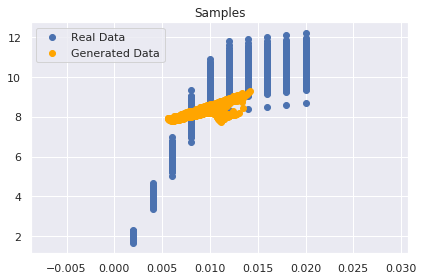

In [21]:
num_examples = 512
#seed = tf.random.normal([num_examples, noise_dim])
seed = tf.random.uniform(minval= -1., maxval= 1., shape=[BATCH_SIZE, noise_dim])
pred = generator(seed, training=False)
samples = generate_batch(batch_size=num_examples)

plot_examples(samples, pred)

tf.Tensor([7.113453e-03 8.134484e+00], shape=(2,), dtype=float32)


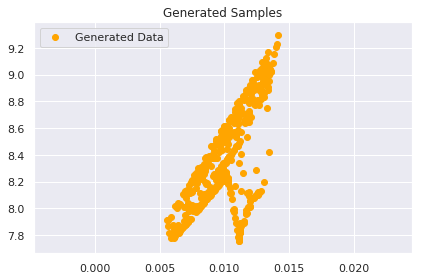

In [22]:
def plot_gen(generated):
    g_ax = plt.scatter(generated[:,0], generated[:,1], label='Generated Data', color='orange')
    plt.legend()
    plt.title('Generated Samples')
    plt.tight_layout()
    
plot_gen(pred)
print(pred[0])